In [41]:
from enum import Enum
from queue import PriorityQueue
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.figsize'] = 14, 14

In [42]:
def create_grid(data, drone_altitude, safety_distance):
    """
    Returns a grid representation of a 2D configuration space
    based on given obstacle data, drone altitude and safety distance
    arguments.
    """
    
#     grid_scale = 1

    # minimum and maximum north coordinates
    north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.max(data[:, 0] + data[:, 3]))

    # minimum and maximum east coordinates
    east_min = np.floor(np.min(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.max(data[:, 1] + data[:, 4]))

    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil((north_max - north_min + 1)))
    east_size = int(np.ceil((east_max - east_min + 1)))

    # Initialize an empty grid
    grid = np.zeros((north_size, east_size))

    # Populate the grid with obstacles
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        if alt + d_alt + safety_distance > drone_altitude:
            obstacle = [
                int(np.clip(north - d_north - safety_distance - north_min, 0, north_size-1)),
                int(np.clip(north + d_north + safety_distance - north_min, 0, north_size-1)),
                int(np.clip(east - d_east - safety_distance - east_min, 0, east_size-1)),
                int(np.clip(east + d_east + safety_distance - east_min, 0, east_size-1)),
            ]
            grid[obstacle[0]:obstacle[1]+1, obstacle[2]:obstacle[3]+1] = 1

    return grid, int(north_min), int(east_min)


In [43]:
# Assume all actions cost the same.
class Action(Enum):
    """
    An action is represented by a 3 element tuple.

    The first 2 values are the delta of the action relative
    to the current grid position. The third and final value
    is the cost of performing the action.
    """
    FORWARD = (-1,0,1)
    BACKWARD= (1,0,1)
    RIGHT= (0,1,1)
    LEFT= (0,-1,1)
    FORWARD_RIGHT = (-1,1,np.sqrt(2))
    FORWARD_LEFT= (-1,-1,np.sqrt(2))
    BACKWARD_RIGHT= (1,1,np.sqrt(2))
    BACKWARD_LEFT= (1,-1,np.sqrt(2))

    @property
    def cost(self):
        return self.value[2]

    @property
    def delta(self):
        return (self.value[0], self.value[1])

In [44]:

class Action_3d(Enum):
    """
    An action is represented by a 3 element tuple.

    The first 2 values are the delta of the action relative
    to the current grid position. The third and final value
    is the cost of performing the action.
    """
    # Plane - (0)
    FORWARD = (-1, 0, 0, 1)
    BACKWARD = (1, 0, 0, 1)
    RIGHT = (0, 1, 0, 1)
    LEFT = (0, -1, 0, 1)
    FORWARD_RIGHT = (-1, 1, 0, np.sqrt(2))
    FORWARD_LEFT = (-1, -1, 0, np.sqrt(2))
    BACKWARD_RIGHT = (1, 1, 0, np.sqrt(2))
    BACKWARD_LEFT = (1, -1, 0, np.sqrt(2))

    # Plane - (+1)
    UP = (0, 0, 1, 1)
    FORWARD_UP = (-1, 0, 1, np.sqrt(2))
    BACKWARD_UP = (1, 0, 1, np.sqrt(2))
    RIGHT_UP = (0, 1, 1, np.sqrt(2))
    LEFT_UP = (0, -1, 1, np.sqrt(2))
    FORWARD_RIGHT_UP = (-1, 1, 1, np.sqrt(np.sqrt(2)+1))
    FORWARD_LEFT_UP = (-1, -1, 1, np.sqrt(np.sqrt(2)+1))
    BACKWARD_RIGHT_UP = (1, 1, 1, np.sqrt(np.sqrt(2)+1))
    BACKWARD_LEFT_UP = (1, -1, 1, np.sqrt(np.sqrt(2)+1))
    # Plane - (-1)
    DOWN = (0, 0, -1, 1)
    FORWARD_DOWN = (-1, 0, -1, np.sqrt(2))
    BACKWARD_DOWN = (1, 0, -1, np.sqrt(2))
    RIGHT_DOWN = (0, 1, -1, np.sqrt(2))
    LEFT_DOWN = (0, -1, -1, np.sqrt(2))
    FORWARD_RIGHT_DOWN = (-1, 1, -1, np.sqrt(np.sqrt(2)+1))
    FORWARD_LEFT_DOWN = (-1, -1, -1, np.sqrt(np.sqrt(2)+1))
    BACKWARD_RIGHT_DOWN = (1, 1, -1, np.sqrt(np.sqrt(2)+1))
    BACKWARD_LEFT_DOWN = (1, -1, -1, np.sqrt(np.sqrt(2)+1))

    @property
    def cost(self):
        return self.value[3]

    @property
    def delta(self):
        return (self.value[0], self.value[1], self.value[2])

In [45]:
def valid_actions(grid, current_node):
    """
    Returns a list of valid actions given a grid and current node.
    """
    valid_actions = None
    if len(grid.shape) < 3:
        valid_actions = list(Action)
        n, m = grid.shape[0] - 1, grid.shape[1] - 1
        x, y = current_node
        # check if the node is off the grid or
        # it's an obstacle
        if x - 1 < 0 or grid[x - 1, y] == 1:
            valid_actions.remove(Action.FORWARD)
        if x + 1 > n or grid[x + 1, y] == 1:
            valid_actions.remove(Action.BACKWARD)
        if y - 1 < 0 or grid[x, y - 1] == 1:
            valid_actions.remove(Action.LEFT)
        if y + 1 > m or grid[x, y + 1] == 1:
            valid_actions.remove(Action.RIGHT)

        if x - 1 < 0 or y - 1 < 0 or grid[x - 1, y - 1] == 1:
            valid_actions.remove(Action.FORWARD_LEFT)
        if x - 1 < 0 or y + 1 > m or grid[x - 1, y + 1] == 1:
            valid_actions.remove(Action.FORWARD_RIGHT)
        if x + 1 > n or y - 1 < 0 or grid[x + 1, y - 1] == 1:
            valid_actions.remove(Action.BACKWARD_LEFT)
        if x + 1 > n or y + 1 > m or grid[x + 1, y + 1] == 1:
            valid_actions.remove(Action.BACKWARD_RIGHT)

    else:
        valid_actions = list(Action_3d)
        n, m, k = grid.shape[0] - 1, grid.shape[1] - 1, grid.shape[2] - 1
        x, y, z = current_node
        # PLANE - (0)
        if x - 1 < 0 or grid[x - 1, y, z] == 1:
            valid_actions.remove(Action_3d.FORWARD)
        if x + 1 > n or grid[x + 1, y, z] == 1:
            valid_actions.remove(Action_3d.BACKWARD)
        if y - 1 < 0 or grid[x, y - 1, z] == 1:
            valid_actions.remove(Action_3d.LEFT)
        if y + 1 > m or grid[x, y + 1, z] == 1:
            valid_actions.remove(Action_3d.RIGHT)

        if x - 1 < 0 or y - 1 < 0 or grid[x - 1, y - 1, z] == 1:
            valid_actions.remove(Action_3d.FORWARD_LEFT)
        if x - 1 < 0 or y + 1 > m or grid[x - 1, y + 1, z] == 1:
            valid_actions.remove(Action_3d.FORWARD_RIGHT)
        if x + 1 > n or y - 1 < 0 or grid[x + 1, y - 1, z] == 1:
            valid_actions.remove(Action_3d.BACKWARD_LEFT)
        if x + 1 > n or y + 1 > m or grid[x + 1, y + 1, z] == 1:
            valid_actions.remove(Action_3d.BACKWARD_RIGHT)
        # PLANE - (+1)
        if z + 1 > k or grid[x, y, z + 1] == 1:
            valid_actions.remove(Action_3d.UP)
        if x - 1 < 0 or z + 1 > k or grid[x - 1, y, z + 1] == 1:
            valid_actions.remove(Action_3d.FORWARD_UP)
        if x + 1 > n or z + 1 > k or grid[x + 1, y, z + 1] == 1:
            valid_actions.remove(Action_3d.BACKWARD_UP)
        if y - 1 < 0 or z + 1 > k or grid[x, y - 1, z + 1] == 1:
            valid_actions.remove(Action_3d.LEFT_UP)
        if y + 1 > m or z + 1 > k or grid[x, y + 1, z + 1] == 1:
            valid_actions.remove(Action_3d.RIGHT_UP)

        if x - 1 < 0 or y - 1 < 0 or z + 1 > k or grid[x - 1, y - 1, z + 1] == 1:
            valid_actions.remove(Action_3d.FORWARD_LEFT_UP)
        if x - 1 < 0 or y + 1 > m or z + 1 > k or grid[x - 1, y + 1, z + 1] == 1:
            valid_actions.remove(Action_3d.FORWARD_RIGHT_UP)
        if x + 1 > n or y - 1 < 0 or z + 1 > k or grid[x + 1, y - 1, z + 1] == 1:
            valid_actions.remove(Action_3d.BACKWARD_LEFT_UP)
        if x + 1 > n or y + 1 > m or z + 1 > k or grid[x + 1, y + 1, z + 1] == 1:
            valid_actions.remove(Action_3d.BACKWARD_RIGHT_UP)

        # PLANE - (-1)
        if z - 1 < 0 or grid[x, y, z - 1] == 1:
            valid_actions.remove(Action_3d.DOWN)
        if x - 1 < 0 or z - 1 < 0 or grid[x - 1, y, z - 1] == 1:
            valid_actions.remove(Action_3d.FORWARD_DOWN)
        if x + 1 > n or z - 1 < 0 or grid[x + 1, y, z - 1] == 1:
            valid_actions.remove(Action_3d.BACKWARD_DOWN)
        if y - 1 < 0 or z - 1 < 0 or grid[x, y - 1, z - 1] == 1:
            valid_actions.remove(Action_3d.LEFT_DOWN)
        if y + 1 > m or z - 1 < 0 or grid[x, y + 1, z - 1] == 1:
            valid_actions.remove(Action_3d.RIGHT_DOWN)

        if x - 1 < 0 or y - 1 < 0 or z - 1 < 0 or grid[x - 1, y - 1, z - 1] == 1:
            valid_actions.remove(Action_3d.FORWARD_LEFT_DOWN)
        if x - 1 < 0 or y + 1 > m or z - 1 < 0 or grid[x - 1, y + 1, z - 1] == 1:
            valid_actions.remove(Action_3d.FORWARD_RIGHT_DOWN)
        if x + 1 > n or y - 1 < 0 or z - 1 < 0 or grid[x + 1, y - 1, z - 1] == 1:
            valid_actions.remove(Action_3d.BACKWARD_LEFT_DOWN)
        if x + 1 > n or y + 1 > m or z - 1 < 0 or grid[x + 1, y + 1, z - 1] == 1:
            valid_actions.remove(Action_3d.BACKWARD_RIGHT_DOWN)

    return valid_actions

In [46]:
def heuristic(position, goal_position):
    return np.linalg.norm(np.array(position) - np.array(goal_position))

In [47]:
def collinearity_3D_int(p1, p2, p3, epsilon=1e-6): 
    # TODO: Create the matrix out of three points
    # TODO: Calculate the determinant of the matrix. 
    # TODO: Set collinear to True if the determinant is less than epsilon
    [a,b,c]=p1
    [d,e,f]=p2
    [g,h,i]=p3
    if c==0 and f==0 and i==0:
        c = 1 ; f = 1 ;i =1;

    det = a*e*i+b*f*g+c*d*h-c*e*g-b*d*i-a*f*h
    
    return det==0

In [48]:
def prune_path(path):
    pruned_path=[]
    pruned_path.append(path[0])
    # TODO: prune the path!
#     print(path[0],path[1])
    for i,p in enumerate(path[1:len(path)-1]):
        p1,p2,p3 = (path[i-1],path[i],path[i+1])
        if len(p2) > 2:
            a=np.array(p1)
            b=np.array(p2)
            c=np.array(p3)
        else:
            a=np.array(p1+(1,))
            b=np.array(p2+(1,))
            c=np.array(p3+(1,))
        if not collinearity_3D_int(a,b,c):
            pruned_path.append(p2)
    pruned_path.append(path[len(path)-1])
    return pruned_path

In [49]:
def a_star(grid, h, start, goal):
    """
    Given a grid and heuristic function returns
    the lowest cost path from start to goal.
    """
    is3D = len(grid.shape) > 2
    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False

    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:
            print('Found a path.')
            found = True
            break
        else:
            # Get the new vertexes connected to the current vertex
            for a in valid_actions(grid, current_node):
                next_node = None
                if is3D:
                    next_node = (current_node[0] + a.delta[0], 
                                 current_node[1] + a.delta[1],
                                 current_node[2] + a.delta[2])
                else:
                    next_node = (current_node[0] + a.delta[0], current_node[1] + a.delta[1])
                new_cost = current_cost + a.cost + h(next_node, goal)

                if next_node not in visited:
                    visited.add(next_node)
                    queue.put((new_cost, next_node))

                    branch[next_node] = (new_cost, current_node, a)

    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost


In [50]:
# Read in the obstacle data
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(open(filename).readlines()[0].replace(',','').split())

['lat0', '37.792480', 'lon0', '-122.397450']


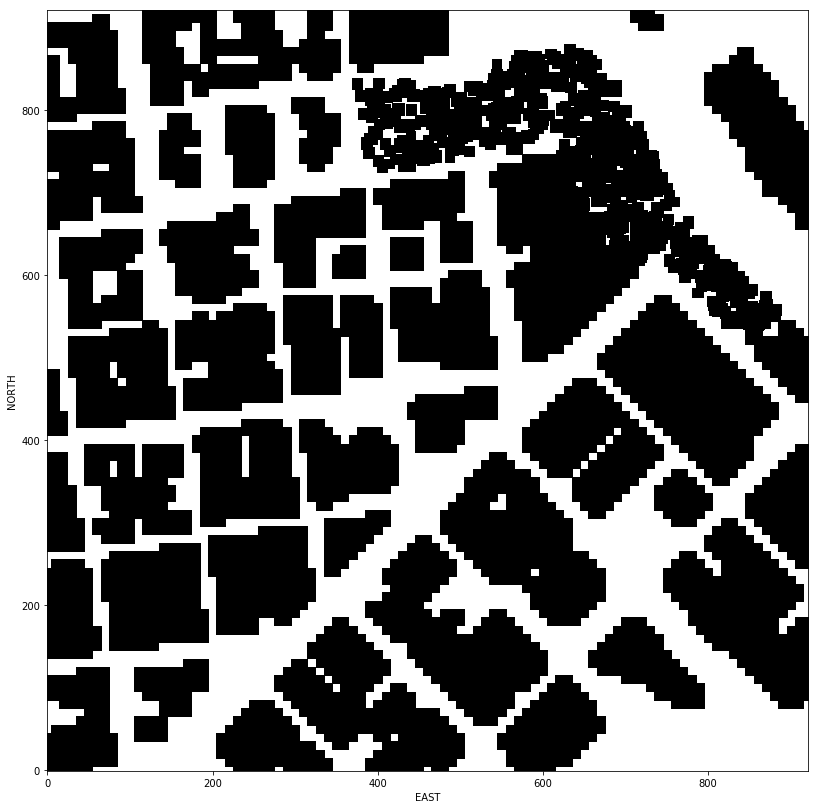

In [51]:
# Define a flying altitude (feel free to change this)
drone_altitude = 5
safety_distance = 5
grid,_,_ = create_grid(data, drone_altitude, safety_distance)
# equivalent to
# plt.imshow(np.flip(grid, 0))
# Plot it up!
plt.imshow(grid, origin='lower', cmap='Greys')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()


Found a path.
1020
87


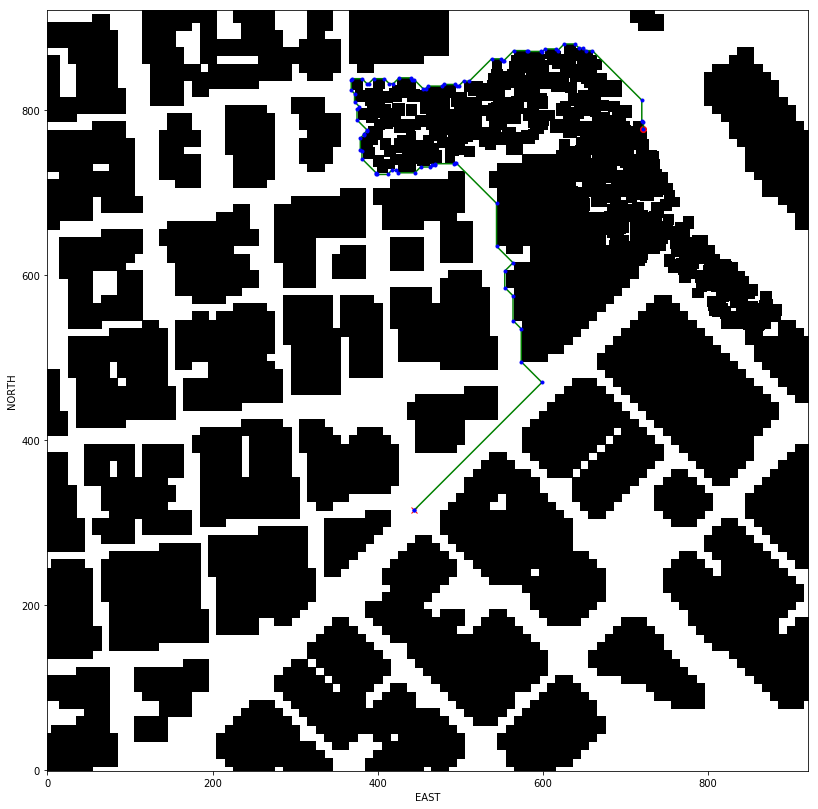

In [52]:
#(315, 444) (685, 384)
start = (315, 444)
goal =  (777, 722)
path,_ = a_star(grid,heuristic,start,goal)
print(len(path))
path=prune_path(path)
print(len(path))

# equivalent to
plt.imshow(np.flip(grid, 0))
# Plot it up!
plt.imshow(grid, origin='lower', cmap='Greys')
plt.plot(start[1], start[0], 'rx')
plt.plot(goal[1], goal[0], 'ro')

pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'g')
for [x,y] in pp:
    plt.plot(y, x, 'b.')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [57]:
def create_voxmap(data, voxel_size=5,safety_distance = 5):
    """
    Returns a grid representation of a 3D configuration space
    based on given obstacle data.
    DATA : columns  xx ,  yy ,  zz  and  δx ,  δy ,  δz.
    The `voxel_size` argument sets the resolution of the voxel map. 
    """


    # minimum and maximum north coordinates
    north_min = np.floor(np.amin(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.amax(data[:, 0] + data[:, 3]))

    # minimum and maximum east coordinates
    east_min = np.floor(np.amin(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.amax(data[:, 1] + data[:, 4]))

    alt_max = np.ceil(np.amax(data[:, 2] + data[:, 5]))
    
    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil((north_max - north_min))) // voxel_size
    east_size = int(np.ceil((east_max - east_min))) // voxel_size
    alt_size = int(alt_max) // voxel_size

    voxmap = np.zeros((north_size, east_size, alt_size))
    
    for i in range(data.shape[0]):
        x,y,z,dx,dy,dz = data[i]
        
        x_from = int((x-north_min-safety_distance-dx)/voxel_size)
        x_to = int((x-north_min+safety_distance+dx)/voxel_size)
        
        y_from = int((y-east_min-safety_distance-dy)/voxel_size)
        y_to = int((y-east_min+safety_distance+dy)/voxel_size)
        
#         x_from = int(x-north_min-dx)/voxel_size
        z_to = int((z+dz+safety_distance)/voxel_size)
        voxmap[x_from:x_to,y_from:y_to,0:z_to]=1
#         voxmap[x:x+1,y:y+1,0:z]=True
        continue
        # TODO: fill in the voxels that are part of an obstacle with `True`
        #
        # i.e. grid[0:5, 20:26, 2:7] = True

    return voxmap,int(north_min),int(east_max)

(31, 44, 0)
(66, 52, 1)
Found a path.
36
10
[[31 44  0]
 [31 44  0]
 [39 52  0]
 [40 52  0]
 [42 52  2]
 [47 52  2]
 [48 52  3]
 [61 52  3]
 [63 52  1]
 [66 52  1]]
False
False
False
False
False
False
False
False
False
False


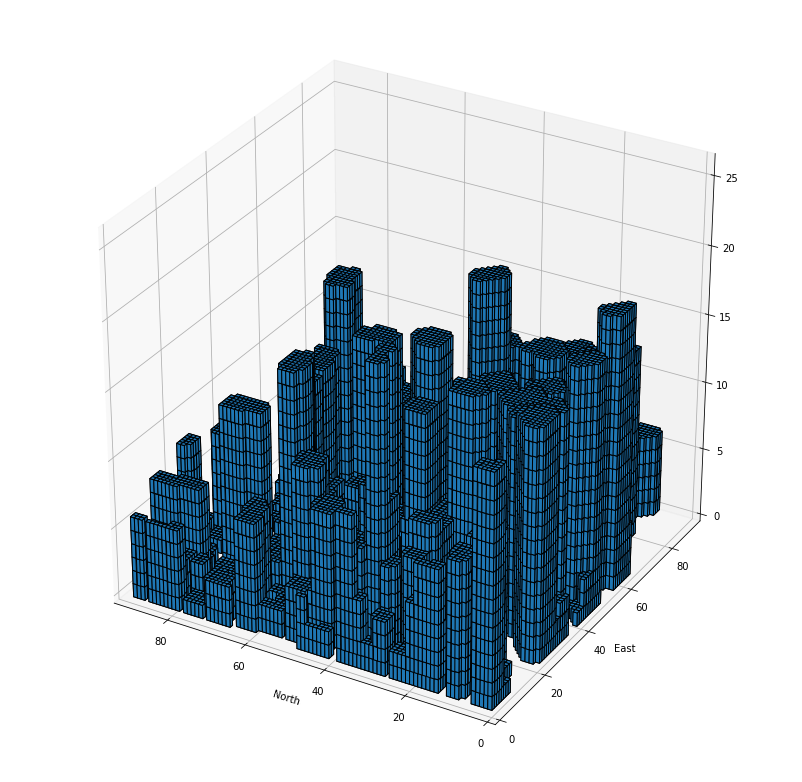

In [58]:
voxel_size = 10
voxmap,_,_ = create_voxmap(data, voxel_size,safety_distance)
# print((voxmap.shape))

start = (316, 445)
goal = (669, 526)

start3d = tuple([int(x/voxel_size) for x in start])+(int(2/voxel_size),)
goal3d = tuple([int(x/voxel_size) for x in goal])+(int(15/voxel_size),)

# start3d = (42,7,0)
# goal3d  = (35,85,15)

print(start3d)
print(goal3d )

#start3d = (16, 22, 1)
#goal3d = (26, 27, 2

# size = (100, 100, 30)
# voxmap = np.zeros(size)
# voxmap[20:50, 50:70, 0:25] = 1
# voxmap[35:50, 13:33, 0:20] = 1

path=[]
path, _ = a_star(voxmap, heuristic, start3d, goal3d)
# path = [[p[1],p[0],p[2]] for p in path]
print(len(path))
path = np.array(prune_path(path))
# path=np.array(path)
print(len(path))
print(path)

# path[:,2]=25
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.voxels(voxmap,edgecolors='k')
# ax.voxels(voxmap)
if len(path) > 0:
    ax.plot(path[:, 0], path[:, 1], path[:, 2], 'g')
    ax.scatter(path[:, 0], path[:, 1], path[:, 2], 'ro')
ax.scatter(start3d[0], start3d[1], start3d[2], 'yx')
ax.scatter(goal3d[0], goal3d[1], goal3d[2], 'gx')


ax.set_xlim(voxmap.shape[1], 0)
ax.set_ylim(0, voxmap.shape[0])
# add 100 to the height so the buildings aren't so tall
ax.set_zlim(0, voxmap.shape[2] + 5)

plt.ylabel('East')
plt.xlabel('North')


for x,y,z in path:
    print(voxmap[x,y,z]==1)

plt.show()
